In [1]:
import random
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image, ImageDraw
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import metrics
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Get Data

In [2]:
test_df = pd.read_csv('test_simplified.csv')
test_df.shape

(112199, 3)

In [3]:
# Get names of all train csv files with the pattern match below
fnames = glob('train_simplified/*.csv')

In [4]:
rows = 200
# Get n rows from all the csv files and append them into one dataframe
train_df = pd.DataFrame(columns=pd.read_csv(fnames[0], nrows=20).columns)
for name in fnames:
    data = pd.read_csv(name, nrows=rows)
    train_df = train_df.append(data)
train_df = train_df.reset_index().drop('index', axis=1)
# Get only those which were correctly recognized
train_df = train_df[train_df['recognized'] == True]

In [5]:
# Convert the drawing column to matrix
train_df['drawing'] = train_df['drawing'].apply(ast.literal_eval)
test_df['drawing'] = test_df['drawing'].apply(ast.literal_eval)

In [6]:
# train_df.head()
# train_df['recognized'].value_counts()

# Draw Sample

In [7]:
train_df.sample(10)

,countrycode,drawing,key_id,recognized,timestamp,word
49514,US,"[[[215, 188, 124, 79, 0, 31, 107, 120, 158, 19...",5105205551038464,True,2017-03-24 19:24:26.779330,string bean
13540,CA,"[[[198, 191, 171, 143, 103, 93, 92, 95, 118, 1...",5078978450685952,True,2017-03-07 22:32:01.857190,broom
380,RO,"[[[0, 6, 16, 65, 94, 122, 143, 150, 144, 143, ...",5583634624937984,True,2017-03-14 18:09:27.422900,bucket
15892,US,"[[[21, 7, 0, 0, 7, 16, 20, 18, 17, 21, 32, 42,...",4722079154831360,True,2017-01-30 22:14:42.260100,ice cream
17745,US,"[[[1, 6, 5, 46, 147, 159, 177, 192, 202, 215, ...",5342310629900288,True,2017-03-27 22:42:48.969370,suitcase
64934,US,"[[[168, 168, 162, 141, 127, 99, 51, 17, 0, 5, ...",6170997591900160,True,2017-03-28 17:59:43.837050,soccer ball
40223,US,"[[[101, 98, 98, 101, 115, 120, 119, 107, 100],...",6097761340489728,True,2017-01-27 02:52:51.692920,mosquito
13520,US,"[[[51, 24, 38, 50, 47, 36, 29, 63, 58, 74, 53,...",4983237875073024,True,2017-03-28 18:12:26.430520,broom
40295,NO,"[[[26, 13, 7, 0, 1, 9, 19, 48, 53, 53, 47, 30,...",6678313290432512,True,2017-03-27 13:51:13.192410,mosquito
23660,GU,"[[[20, 12, 3, 3, 9, 20, 42, 118, 172, 180, 186...",6254812251291648,True,2017-03-13 14:54:16.870450,van


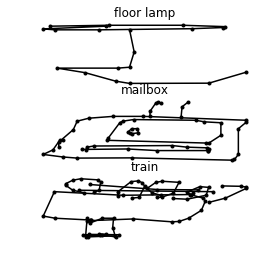

In [8]:
n_samp = 3
train_df_sample = train_df.sample(n_samp)
plt.figure(figsize=(4,4))
for i in range(n_samp):
    draw = train_df_sample.iloc[i]['drawing']
    label = train_df_sample.iloc[i]['word']
    plt.subplot(n_samp,1,i+1)
    for stroke in draw:
        plt.plot(stroke[0], stroke[1], marker='.', color='black')
        plt.title(label)
        plt.axis('off')
plt.show()    

# Convert drawings to images

In [9]:
def draw_it(raw_strokes, output_height, output_width):
    image = Image.new("P", (255,255)
#                       , color=1
            )
    image_draw = ImageDraw.Draw(image)

    for stroke in raw_strokes:
        for i in range(len(stroke[0])-1):

            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=255, width=6)
    # Reduce image size
    image = image.resize((output_height,output_width),Image.ANTIALIAS)
    
    return np.array(image)

In [10]:
output_height = 32
output_width = 32
train_df['img'] = train_df[['drawing']].apply(lambda x: draw_it(x['drawing'], output_height, output_width), axis=1)
test_df['img'] = test_df[['drawing']].apply(lambda x: draw_it(x['drawing'], output_height, output_width), axis=1)

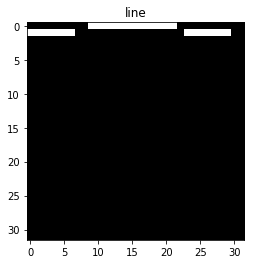

In [11]:
# Show an image
ind = 100
plt.imshow(train_df.iloc[ind]['img'],cmap='gray')
plt.title(train_df.iloc[ind]['word'])
plt.show()

# Create a baseline CNN

In [12]:
batch_size = 10
num_classes = len(fnames)
epochs = 12

### Data Preprocessing

In [13]:
# Shuffle the data
random.seed(111)
train_df = train_df.sample(train_df.shape[0])

In [14]:
# input image dimensions
img_rows, img_cols = output_height, output_width
input_shape = (img_rows, img_cols)

In [15]:
# Reshape the array
imgArr = np.vstack(train_df['img'].values).flatten().reshape((train_df['img'].shape[0], img_rows, img_cols))
imgArr_test = np.vstack(test_df['img'].values).flatten().reshape((test_df['img'].shape[0], img_rows, img_cols))

In [16]:
# In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels] for TF.
# In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In this case, the pixel values are gray scale, the pixel dimension is set to 1.
imgArr = imgArr.reshape(imgArr.shape[0], img_rows, img_cols, 1).astype('float32')
imgArr_test = imgArr_test.reshape(imgArr_test.shape[0], img_rows, img_cols, 1).astype('float32')

In [17]:
y_train = train_df['word']

In [18]:
# Convert class labels from categorical to numerical
unique_classes_list = y_train.unique()
map_class_to_numeric = {k: v for v, k in enumerate(y_train.unique())}
map_numeric_to_class = {v: k for k, v in map_class_to_numeric.iteritems()}
y_train_numeric = y_train.apply(lambda x: map_class_to_numeric[x])

# convert class vectors to binary class matrices
y_train_one_hot = keras.utils.to_categorical(y_train_numeric, num_classes)
num_classes = y_train_one_hot.shape[1]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(imgArr, y_train_one_hot, test_size=0.2)

In [20]:
def top_3_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

### Model Architecture

In [21]:
num_filters = 8 # num of channels / filters
def baseline_conv_model(num_filters):
    model = Sequential()
    model.add(Conv2D(num_filters, (5,5), input_shape=(img_rows,img_cols,1), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*2, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*4, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(2550, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(700, activation='relu'))
    model.add(Dropout(0.2))
#     model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy, 'categorical_crossentropy'])
    return model

In [22]:
model = baseline_conv_model(num_filters)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          4640      
__________

In [23]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 50072 samples, validate on 12518 samples
Epoch 1/500
 - 133s - loss: 6.9345 - acc: 0.0056 - top_3_accuracy: 0.0154 - categorical_crossentropy: 6.9345 - val_loss: 5.7293 - val_acc: 0.0119 - val_top_3_accuracy: 0.0316 - val_categorical_crossentropy: 5.7293
Epoch 2/500
 - 119s - loss: 5.4774 - acc: 0.0153 - top_3_accuracy: 0.0422 - categorical_crossentropy: 5.4774 - val_loss: 5.2566 - val_acc: 0.0317 - val_top_3_accuracy: 0.0765 - val_categorical_crossentropy: 5.2566
Epoch 3/500
 - 118s - loss: 5.1600 - acc: 0.0304 - top_3_accuracy: 0.0780 - categorical_crossentropy: 5.1600 - val_loss: 4.9928 - val_acc: 0.0529 - val_top_3_accuracy: 0.1258 - val_categorical_crossentropy: 4.9928
Epoch 4/500
 - 126s - loss: 4.9415 - acc: 0.0455 - top_3_accuracy: 0.1085 - categorical_crossentropy: 4.9415 - val_loss: 4.7546 - val_acc: 0.0812 - val_top_3_accuracy: 0.1737 - val_categorical_crossentropy: 4.7546
Epoch 5/500
 - 145s - loss: 4.7493 - acc: 0.0614 - top_3_accuracy: 0.1410 - categorical_crosse

 - 92s - loss: 2.7376 - acc: 0.3233 - top_3_accuracy: 0.5404 - categorical_crossentropy: 2.7376 - val_loss: 2.8085 - val_acc: 0.3429 - val_top_3_accuracy: 0.5551 - val_categorical_crossentropy: 2.8085
Epoch 40/500
 - 91s - loss: 2.7059 - acc: 0.3313 - top_3_accuracy: 0.5491 - categorical_crossentropy: 2.7059 - val_loss: 2.8043 - val_acc: 0.3445 - val_top_3_accuracy: 0.5526 - val_categorical_crossentropy: 2.8043
Epoch 41/500
 - 92s - loss: 2.6976 - acc: 0.3326 - top_3_accuracy: 0.5495 - categorical_crossentropy: 2.6976 - val_loss: 2.8045 - val_acc: 0.3450 - val_top_3_accuracy: 0.5512 - val_categorical_crossentropy: 2.8045
Epoch 42/500
 - 91s - loss: 2.6646 - acc: 0.3354 - top_3_accuracy: 0.5547 - categorical_crossentropy: 2.6646 - val_loss: 2.7932 - val_acc: 0.3496 - val_top_3_accuracy: 0.5566 - val_categorical_crossentropy: 2.7932
Epoch 43/500
 - 92s - loss: 2.6374 - acc: 0.3413 - top_3_accuracy: 0.5614 - categorical_crossentropy: 2.6374 - val_loss: 2.7808 - val_acc: 0.3500 - val_top_3

Epoch 78/500
 - 93s - loss: 2.1330 - acc: 0.4306 - top_3_accuracy: 0.6650 - categorical_crossentropy: 2.1330 - val_loss: 2.7732 - val_acc: 0.3565 - val_top_3_accuracy: 0.5685 - val_categorical_crossentropy: 2.7732
Epoch 79/500
 - 94s - loss: 2.1216 - acc: 0.4334 - top_3_accuracy: 0.6689 - categorical_crossentropy: 2.1216 - val_loss: 2.7758 - val_acc: 0.3606 - val_top_3_accuracy: 0.5678 - val_categorical_crossentropy: 2.7758
Epoch 80/500
 - 92s - loss: 2.0973 - acc: 0.4381 - top_3_accuracy: 0.6707 - categorical_crossentropy: 2.0973 - val_loss: 2.7602 - val_acc: 0.3640 - val_top_3_accuracy: 0.5750 - val_categorical_crossentropy: 2.7602
Epoch 81/500
 - 93s - loss: 2.0982 - acc: 0.4388 - top_3_accuracy: 0.6719 - categorical_crossentropy: 2.0982 - val_loss: 2.7426 - val_acc: 0.3639 - val_top_3_accuracy: 0.5760 - val_categorical_crossentropy: 2.7426
Epoch 82/500
 - 92s - loss: 2.0938 - acc: 0.4409 - top_3_accuracy: 0.6771 - categorical_crossentropy: 2.0938 - val_loss: 2.7652 - val_acc: 0.358

Epoch 117/500
 - 92s - loss: 1.8039 - acc: 0.5003 - top_3_accuracy: 0.7368 - categorical_crossentropy: 1.8039 - val_loss: 2.8331 - val_acc: 0.3587 - val_top_3_accuracy: 0.5721 - val_categorical_crossentropy: 2.8331
Epoch 118/500
 - 93s - loss: 1.7916 - acc: 0.5044 - top_3_accuracy: 0.7374 - categorical_crossentropy: 1.7916 - val_loss: 2.9038 - val_acc: 0.3549 - val_top_3_accuracy: 0.5607 - val_categorical_crossentropy: 2.9038
Epoch 119/500
 - 91s - loss: 1.8033 - acc: 0.5051 - top_3_accuracy: 0.7359 - categorical_crossentropy: 1.8033 - val_loss: 2.8791 - val_acc: 0.3548 - val_top_3_accuracy: 0.5641 - val_categorical_crossentropy: 2.8791
Epoch 120/500
 - 92s - loss: 1.7715 - acc: 0.5081 - top_3_accuracy: 0.7420 - categorical_crossentropy: 1.7715 - val_loss: 2.8713 - val_acc: 0.3577 - val_top_3_accuracy: 0.5676 - val_categorical_crossentropy: 2.8713
Epoch 121/500
 - 92s - loss: 1.7725 - acc: 0.5098 - top_3_accuracy: 0.7427 - categorical_crossentropy: 1.7725 - val_loss: 2.8671 - val_acc: 

Epoch 156/500
 - 92s - loss: 1.5971 - acc: 0.5462 - top_3_accuracy: 0.7765 - categorical_crossentropy: 1.5971 - val_loss: 2.9629 - val_acc: 0.3523 - val_top_3_accuracy: 0.5599 - val_categorical_crossentropy: 2.9629
Epoch 157/500
 - 93s - loss: 1.6033 - acc: 0.5457 - top_3_accuracy: 0.7762 - categorical_crossentropy: 1.6033 - val_loss: 2.9887 - val_acc: 0.3489 - val_top_3_accuracy: 0.5562 - val_categorical_crossentropy: 2.9887
Epoch 158/500
 - 91s - loss: 1.5978 - acc: 0.5485 - top_3_accuracy: 0.7767 - categorical_crossentropy: 1.5978 - val_loss: 2.9463 - val_acc: 0.3533 - val_top_3_accuracy: 0.5581 - val_categorical_crossentropy: 2.9463
Epoch 159/500
 - 92s - loss: 1.5718 - acc: 0.5567 - top_3_accuracy: 0.7845 - categorical_crossentropy: 1.5718 - val_loss: 2.9375 - val_acc: 0.3588 - val_top_3_accuracy: 0.5698 - val_categorical_crossentropy: 2.9375
Epoch 160/500
 - 91s - loss: 1.5682 - acc: 0.5588 - top_3_accuracy: 0.7845 - categorical_crossentropy: 1.5682 - val_loss: 2.9543 - val_acc: 

Epoch 195/500
 - 92s - loss: 1.4676 - acc: 0.5836 - top_3_accuracy: 0.8038 - categorical_crossentropy: 1.4676 - val_loss: 3.0946 - val_acc: 0.3457 - val_top_3_accuracy: 0.5526 - val_categorical_crossentropy: 3.0946
Epoch 196/500
 - 95s - loss: 1.4480 - acc: 0.5885 - top_3_accuracy: 0.8056 - categorical_crossentropy: 1.4480 - val_loss: 3.0196 - val_acc: 0.3592 - val_top_3_accuracy: 0.5632 - val_categorical_crossentropy: 3.0196
Epoch 197/500
 - 99s - loss: 1.4644 - acc: 0.5828 - top_3_accuracy: 0.8038 - categorical_crossentropy: 1.4644 - val_loss: 3.0078 - val_acc: 0.3548 - val_top_3_accuracy: 0.5600 - val_categorical_crossentropy: 3.0078
Epoch 198/500
 - 98s - loss: 1.4606 - acc: 0.5830 - top_3_accuracy: 0.8048 - categorical_crossentropy: 1.4606 - val_loss: 3.0444 - val_acc: 0.3502 - val_top_3_accuracy: 0.5568 - val_categorical_crossentropy: 3.0444
Epoch 199/500
 - 93s - loss: 1.4550 - acc: 0.5832 - top_3_accuracy: 0.8071 - categorical_crossentropy: 1.4550 - val_loss: 3.0173 - val_acc: 

Epoch 234/500
 - 63s - loss: 1.3634 - acc: 0.6065 - top_3_accuracy: 0.8238 - categorical_crossentropy: 1.3634 - val_loss: 3.0911 - val_acc: 0.3552 - val_top_3_accuracy: 0.5610 - val_categorical_crossentropy: 3.0911
Epoch 235/500
 - 62s - loss: 1.3821 - acc: 0.6038 - top_3_accuracy: 0.8201 - categorical_crossentropy: 1.3821 - val_loss: 3.1133 - val_acc: 0.3500 - val_top_3_accuracy: 0.5552 - val_categorical_crossentropy: 3.1133
Epoch 236/500
 - 63s - loss: 1.3587 - acc: 0.6125 - top_3_accuracy: 0.8241 - categorical_crossentropy: 1.3587 - val_loss: 3.1345 - val_acc: 0.3513 - val_top_3_accuracy: 0.5482 - val_categorical_crossentropy: 3.1345
Epoch 237/500
 - 63s - loss: 1.3744 - acc: 0.6085 - top_3_accuracy: 0.8239 - categorical_crossentropy: 1.3744 - val_loss: 3.1437 - val_acc: 0.3495 - val_top_3_accuracy: 0.5522 - val_categorical_crossentropy: 3.1437
Epoch 238/500
 - 63s - loss: 1.3642 - acc: 0.6079 - top_3_accuracy: 0.8232 - categorical_crossentropy: 1.3642 - val_loss: 3.1190 - val_acc: 

Epoch 273/500
 - 62s - loss: 1.3168 - acc: 0.6219 - top_3_accuracy: 0.8331 - categorical_crossentropy: 1.3168 - val_loss: 3.1697 - val_acc: 0.3466 - val_top_3_accuracy: 0.5462 - val_categorical_crossentropy: 3.1697
Epoch 274/500
 - 63s - loss: 1.3063 - acc: 0.6246 - top_3_accuracy: 0.8333 - categorical_crossentropy: 1.3063 - val_loss: 3.1877 - val_acc: 0.3473 - val_top_3_accuracy: 0.5466 - val_categorical_crossentropy: 3.1877
Epoch 275/500
 - 63s - loss: 1.2952 - acc: 0.6258 - top_3_accuracy: 0.8350 - categorical_crossentropy: 1.2952 - val_loss: 3.1741 - val_acc: 0.3498 - val_top_3_accuracy: 0.5530 - val_categorical_crossentropy: 3.1741
Epoch 276/500
 - 63s - loss: 1.2980 - acc: 0.6254 - top_3_accuracy: 0.8368 - categorical_crossentropy: 1.2980 - val_loss: 3.1812 - val_acc: 0.3479 - val_top_3_accuracy: 0.5510 - val_categorical_crossentropy: 3.1812
Epoch 277/500
 - 62s - loss: 1.2841 - acc: 0.6308 - top_3_accuracy: 0.8376 - categorical_crossentropy: 1.2841 - val_loss: 3.1896 - val_acc: 

Epoch 312/500
 - 63s - loss: 1.2434 - acc: 0.6405 - top_3_accuracy: 0.8459 - categorical_crossentropy: 1.2434 - val_loss: 3.2541 - val_acc: 0.3483 - val_top_3_accuracy: 0.5460 - val_categorical_crossentropy: 3.2541
Epoch 313/500
 - 62s - loss: 1.2602 - acc: 0.6339 - top_3_accuracy: 0.8417 - categorical_crossentropy: 1.2602 - val_loss: 3.1833 - val_acc: 0.3542 - val_top_3_accuracy: 0.5562 - val_categorical_crossentropy: 3.1833
Epoch 314/500
 - 63s - loss: 1.2504 - acc: 0.6389 - top_3_accuracy: 0.8455 - categorical_crossentropy: 1.2504 - val_loss: 3.2516 - val_acc: 0.3491 - val_top_3_accuracy: 0.5506 - val_categorical_crossentropy: 3.2516
Epoch 315/500
 - 64s - loss: 1.2321 - acc: 0.6439 - top_3_accuracy: 0.8480 - categorical_crossentropy: 1.2321 - val_loss: 3.2069 - val_acc: 0.3516 - val_top_3_accuracy: 0.5560 - val_categorical_crossentropy: 3.2069
Epoch 316/500
 - 71s - loss: 1.2244 - acc: 0.6452 - top_3_accuracy: 0.8479 - categorical_crossentropy: 1.2244 - val_loss: 3.2514 - val_acc: 

Epoch 351/500
 - 64s - loss: 1.2234 - acc: 0.6464 - top_3_accuracy: 0.8493 - categorical_crossentropy: 1.2234 - val_loss: 3.2528 - val_acc: 0.3498 - val_top_3_accuracy: 0.5508 - val_categorical_crossentropy: 3.2528
Epoch 352/500
 - 61s - loss: 1.1874 - acc: 0.6546 - top_3_accuracy: 0.8585 - categorical_crossentropy: 1.1874 - val_loss: 3.2960 - val_acc: 0.3382 - val_top_3_accuracy: 0.5441 - val_categorical_crossentropy: 3.2960
Epoch 353/500
 - 63s - loss: 1.2044 - acc: 0.6536 - top_3_accuracy: 0.8524 - categorical_crossentropy: 1.2044 - val_loss: 3.2959 - val_acc: 0.3429 - val_top_3_accuracy: 0.5452 - val_categorical_crossentropy: 3.2959
Epoch 354/500
 - 63s - loss: 1.2129 - acc: 0.6482 - top_3_accuracy: 0.8517 - categorical_crossentropy: 1.2129 - val_loss: 3.2871 - val_acc: 0.3463 - val_top_3_accuracy: 0.5521 - val_categorical_crossentropy: 3.2871
Epoch 355/500
 - 63s - loss: 1.2081 - acc: 0.6517 - top_3_accuracy: 0.8524 - categorical_crossentropy: 1.2081 - val_loss: 3.2244 - val_acc: 

Epoch 390/500
 - 63s - loss: 1.1560 - acc: 0.6643 - top_3_accuracy: 0.8624 - categorical_crossentropy: 1.1560 - val_loss: 3.3129 - val_acc: 0.3421 - val_top_3_accuracy: 0.5487 - val_categorical_crossentropy: 3.3129
Epoch 391/500
 - 63s - loss: 1.1645 - acc: 0.6623 - top_3_accuracy: 0.8600 - categorical_crossentropy: 1.1645 - val_loss: 3.3025 - val_acc: 0.3483 - val_top_3_accuracy: 0.5537 - val_categorical_crossentropy: 3.3025
Epoch 392/500
 - 63s - loss: 1.1546 - acc: 0.6649 - top_3_accuracy: 0.8606 - categorical_crossentropy: 1.1546 - val_loss: 3.3268 - val_acc: 0.3402 - val_top_3_accuracy: 0.5474 - val_categorical_crossentropy: 3.3268
Epoch 393/500
 - 63s - loss: 1.1830 - acc: 0.6578 - top_3_accuracy: 0.8587 - categorical_crossentropy: 1.1830 - val_loss: 3.2819 - val_acc: 0.3503 - val_top_3_accuracy: 0.5542 - val_categorical_crossentropy: 3.2819
Epoch 394/500
 - 63s - loss: 1.1646 - acc: 0.6623 - top_3_accuracy: 0.8581 - categorical_crossentropy: 1.1646 - val_loss: 3.3009 - val_acc: 

Epoch 429/500
 - 36s - loss: 1.1263 - acc: 0.6738 - top_3_accuracy: 0.8662 - categorical_crossentropy: 1.1263 - val_loss: 3.3675 - val_acc: 0.3415 - val_top_3_accuracy: 0.5425 - val_categorical_crossentropy: 3.3675
Epoch 430/500
 - 36s - loss: 1.1072 - acc: 0.6802 - top_3_accuracy: 0.8695 - categorical_crossentropy: 1.1072 - val_loss: 3.3546 - val_acc: 0.3457 - val_top_3_accuracy: 0.5488 - val_categorical_crossentropy: 3.3546
Epoch 431/500
 - 36s - loss: 1.1248 - acc: 0.6735 - top_3_accuracy: 0.8681 - categorical_crossentropy: 1.1248 - val_loss: 3.3807 - val_acc: 0.3394 - val_top_3_accuracy: 0.5392 - val_categorical_crossentropy: 3.3807
Epoch 432/500
 - 36s - loss: 1.1235 - acc: 0.6727 - top_3_accuracy: 0.8659 - categorical_crossentropy: 1.1235 - val_loss: 3.3327 - val_acc: 0.3432 - val_top_3_accuracy: 0.5457 - val_categorical_crossentropy: 3.3327
Epoch 433/500
 - 36s - loss: 1.1158 - acc: 0.6762 - top_3_accuracy: 0.8683 - categorical_crossentropy: 1.1158 - val_loss: 3.3154 - val_acc: 

Epoch 468/500


KeyboardInterrupt: 

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

In [131]:
# X_train.shape

(27200, 50, 50, 1)